# Compute and plot tide from OTPS2 (TPXO8) fortran code

In [1]:
%matplotlib notebook

In [21]:
import numpy as np
import datetime
import pandas as pd
import urllib2, urllib
import pytides
import os
import subprocess
import copy
from netCDF4 import Dataset
from point_history import getmes

In [3]:
#define point of measurement

In [4]:
point=1870

In [11]:
#start date
t1='20160601.00'

In [12]:
sdate=datetime.datetime.strptime(t1,'%Y%m%d.%H')

In [13]:
#end day
t2='20160630.00'

In [14]:
edate=datetime.datetime.strptime(t2,'%Y%m%d.%H')

## READ tide gauge measurements

In [16]:
t,s,plat,plon,bname,bid = getmes(sdate,edate,point) # measured data

In [28]:
dic0={'time':t, 'Observation':[a for [a,b,c] in s], 'jrc_tide':[b for [a,b,c] in s], 'jrc_ss':[c for [a,b,c] in s]}
dat1=pd.DataFrame(dic0)
dat1=dat1.set_index('time')

In [29]:
dat1['Observation']=pd.to_numeric(dat1['Observation']) # convert string to floats
dat1['jrc_ss']=pd.to_numeric(dat1['jrc_ss']) # convert string to floats
dat1['jrc_tide']=pd.to_numeric(dat1['jrc_tide']) # convert string to floats

In [31]:
dat1.head()

,Observation,jrc_ss,jrc_tide
time,,,
2016-06-01 00:07:00,-0.231,-0.048,-0.183
2016-06-01 00:55:00,-0.200,-0.022,-0.178
2016-06-01 01:17:00,-0.166,-0.005,-0.161
2016-06-01 01:28:00,-0.167,-0.018,-0.149
2016-06-01 01:48:00,-0.146,-0.024,-0.122


<IPython.core.display.Javascript object>


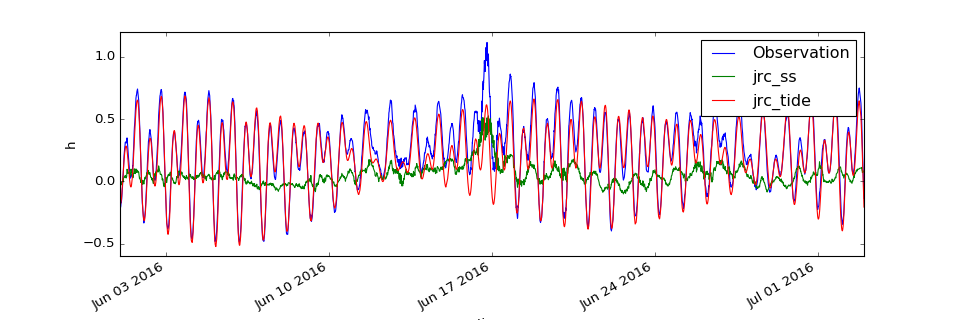

In [32]:
ax1=dat1.plot(figsize=(12,4))
ax1.set_ylabel('h')

## Compute constituents from measurements

In [33]:
demeaned=dat1['Observation'].values-dat1['Observation'].values.mean()

In [34]:
tide=pytides.tide.Tide.decompose(demeaned, dat1['Observation'].index)

In [35]:
constituent = [c.name for c in tide.model['constituent']]

In [36]:
df=pandas.DataFrame(tide.model, index=constituent).drop('constituent', axis=1)

In [37]:
df.sort_values(by='amplitude', ascending=False).head(10) # 10 highest amplitudes

,amplitude,phase
R2,21.404066,11.377840
S2,15.709441,200.810690
K2,11.422366,19.822904
S1,6.325593,345.440477
K1,3.401414,156.804602
P1,3.342979,167.566815
T2,2.938899,188.228280
L2,2.212508,120.329838
lambda2,1.855092,202.349439
nu2,0.712314,197.307650


### validating tide analysis

In [38]:
dates=pandas.date_range(start='2016-06-01',end='2016-06-30',freq='6T')

In [39]:
hours=np.cumsum(np.r_[0, [t.total_seconds()/3600.0 for t in np.diff(dates.to_pydatetime())]])

In [40]:
times=pytides.tide.Tide._times(dates[0], hours)

In [41]:
validation = pandas.Series(tide.at(times) + dat1['jrc_tide'].values.mean(), index=dates)

<IPython.core.display.Javascript object>


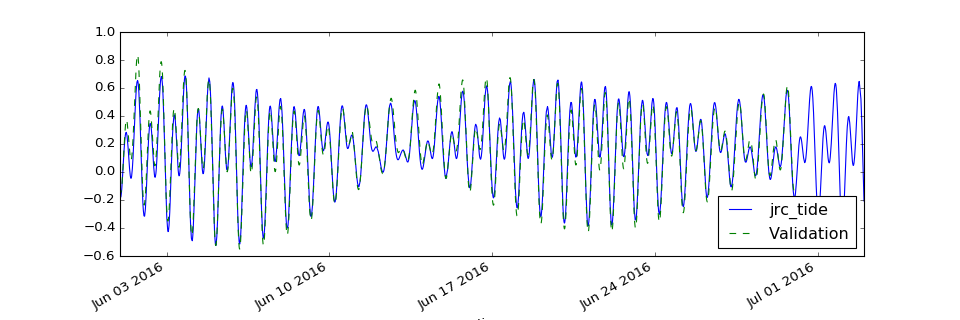

In [42]:
ax = dat1['jrc_tide'].plot(figsize=(12,4))
ax = validation.plot(ax=ax, color='green', linestyle='--', label='Validation')
leg=ax.legend(loc='best')

In [43]:
print('Form number {}, the tide is {}.'.format(tide.form_number()[0], tide.classify()))

Form number 0.214954028522, the tide is semidiurnal.


### Predicting tide 

In [44]:
pdates=pandas.date_range(start='2016-06-30',end='2016-07-08',freq='6T')

In [45]:
phours=np.cumsum(np.r_[0, [t.total_seconds()/3600.0 for t in np.diff(pdates.to_pydatetime())]])

In [46]:
ptimes=pytides.tide.Tide._times(pdates[0], phours)

In [47]:
ptimes

array([Timestamp('2016-06-30 00:00:00', offset='6T'),
       Timestamp('2016-06-30 00:06:00', offset='6T'),
       Timestamp('2016-06-30 00:12:00', offset='6T'), ...,
       Timestamp('2016-07-07 23:48:00', offset='6T'),
       Timestamp('2016-07-07 23:54:00', offset='6T'),
       Timestamp('2016-07-08 00:00:00', offset='6T')], dtype=object)

In [48]:
prediction = pandas.Series(tide.at(ptimes) + dat1['Observation'].values.mean(), index=pdates)

<IPython.core.display.Javascript object>


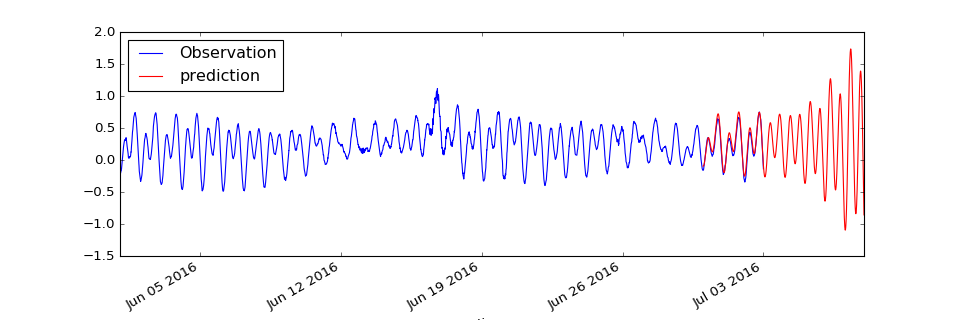

In [49]:
ax = dat1['Observation'].plot(figsize=(12,4))
ax = prediction.plot(ax=ax, color='red', label='prediction')
leg=ax.legend(loc='best')

### Setup the fortan files

In [50]:
path='../TIDES/OTPS2/'

In [51]:
# location
#plon=-5.72
#plat=36.

In [52]:
#dt
delta=datetime.timedelta(hours=1)

In [53]:
with open(path+'lat_lon_time1','w') as f:
    while tin <= ed: 
     f.write('{}  {}  {}  {}  {}  {}  {}  {}\n'.format(plat,plon,tin.year,tin.month,tin.day,tin.hour,tin.minute, tin.second))
     tin += delta

## Evaluate Constituents (TPX08)

In [54]:
ex=subprocess.Popen('./extract_HC < setup.inp', cwd=path, shell=True, stdout=subprocess.PIPE)
stdout=ex.communicate()[0]
print stdout

 DATA/Model_atlas_v1
 Lat/Lon file:lat_lon_time1
 Extract OCEAN tide HC
 Model type: atlas (combined of several models)
 Models in atlas:          30
 Lat limits:     -90.0833359       90.0833359    
 Lon limits:      8.33384171E-02   360.083344    
 Output elevations (m)
 Constituents: m2  s2  n2  k2  k1  o1  p1  q1  m4  ms4 mn4 mm  mf  
 Constituents to include: m2  s2  n2  k2  k1  o1  p1  q1  m4  ms4 mn4 mm  mf  
 Loading local solution grid Med2011             
 Loading local solution elevations Med2011             
 Results are in sample1.out



In [55]:
out=pandas.read_csv(path+'sample1.out',skiprows=[0,1,3],delim_whitespace=True, skipinitialspace=True)#, index_col=['mm.dd.yyyy','hh:mm:ss'] )

In [56]:
out

,Lat,Lon,m2_amp,m2_ph,s2_amp,s2_ph,n2_amp,n2_ph,k2_amp,k2_ph,...,m4_amp,m4_ph,ms4_amp,ms4_ph,mn4_amp,mn4_ph,mm_amp,mm_ph,mf_amp,mf_ph
0,45.418,12.427,0.236,-98.8,0.152,-96.2,0.032,-93.7,0.036,-92.2,...,0.001,107.4,0.001,-149.5,0.001,166.2,0.004,-165.6,0.007,-172.9


In [57]:
cst=out.drop(['Lat','Lon'], axis=1).T

In [58]:
idx=[ c.split('_')[0] for c in cst.index[::2]]

In [59]:
for i in range(np.size(idx)):
    if idx[i] != 'mf' : 
        idx[i]=idx[i][:].upper()
    else:
        idx[i]=idx[i][:1].upper()+idx[i][1:]

In [60]:
pcst=pandas.DataFrame(cst.values.reshape((-1,2)), columns=['amplitude','phase'], index=idx)

In [61]:
#compare the 2 solutions
com=pandas.concat([pcst,df], axis=1).dropna()

In [62]:
com

,amplitude,phase,amplitude,phase
K1,0.145,60.6,3.401414,156.804602
K2,0.036,-92.2,11.422366,19.822904
M2,0.236,-98.8,0.131421,179.818096
M4,0.001,107.4,0.002606,252.605226
MN4,0.001,166.2,0.002819,285.449197
MS4,0.001,-149.5,0.000668,285.837841
Mf,0.007,-172.9,0.172218,294.987425
N2,0.032,-93.7,0.698475,270.334044
O1,0.033,61.9,0.003643,42.593175
P1,0.044,62.2,3.342979,167.566815


## Predict tide (TPX08)

In [63]:
tp=subprocess.Popen('./predict_tide < setup.inp', cwd=path, shell=True, stdout=subprocess.PIPE )
stdout=tp.communicate()[0]
print stdout

 DATA/Model_atlas_v1
 Lat/Lon/Time file:lat_lon_time1
 Predict OCEAN tide
 Interpolate minor constituents
 Model type: atlas (combined of several models)
 Models in atlas:          30
 Lat limits:     -90.0833359       90.0833359    
 Lon limits:      8.33384171E-02   360.083344    
 Predict elevations (m)
 Constituents: m2  s2  n2  k2  k1  o1  p1  q1  m4  ms4 mn4 mm  mf  
 Constituents to include: m2  s2  n2  k2  k1  o1  p1  q1  m4  ms4 mn4 mm  mf  
 Loading local solution grid Med2011
 Loading local solution elevations Med2011             
 Results are in sample1.out



In [64]:
data=pandas.read_csv(path+'sample1.out',skiprows=[0,1,2,3,6],delim_whitespace=True, skipinitialspace=True)#, index_col=['mm.dd.yyyy','hh:mm:ss'] )

In [65]:
#print first row for verification
data[:1]

,Lat,Lon,mm.dd.yyyy,hh:mm:ss,z(m),Depth(m)
0,45.418,12.427,06.01.2016,00:00:00,-0.342,5.0


In [66]:
#merge columns for date
data['time']=data['mm.dd.yyyy'].astype(str).str.cat(data['hh:mm:ss'].astype(str), sep=' ')

In [67]:
#print first row for verification
data[:1]

,Lat,Lon,mm.dd.yyyy,hh:mm:ss,z(m),Depth(m),time
0,45.418,12.427,06.01.2016,00:00:00,-0.342,5.0,06.01.2016 00:00:00


In [68]:
#Delete unwanted columns
dat = data.drop(['Lat','Lon','Depth(m)','mm.dd.yyyy', 'hh:mm:ss'], axis=1)

In [69]:
dat['time']=pandas.to_datetime(dat['time'])

In [70]:
#set time as index
dat=dat.set_index(['time'])

In [71]:
#h=pandas.Series(dat['z(m)'])

<IPython.core.display.Javascript object>


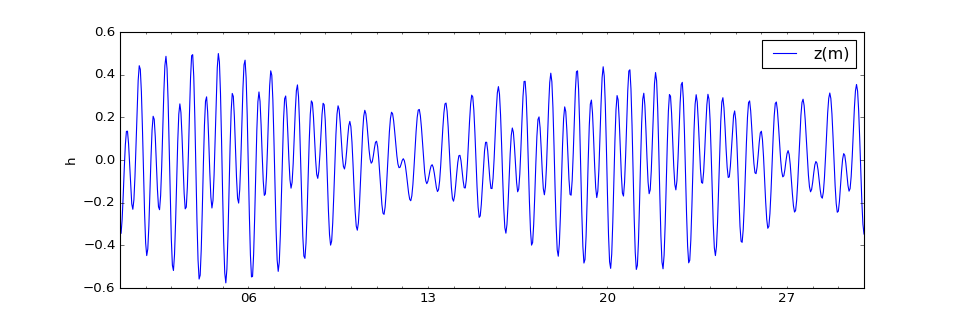

In [72]:
ax=dat.plot(figsize=(12,4))
ax.set_ylabel('h')


In [97]:
#put together
#add2=dat1.join(dat,how='inner')

In [98]:
#add2.plot(x=add2.index,y=['elev','z(m)'], figsize=(12,4))

In [73]:
# Add the mean value of the measurement
dat['z(m)']=dat['z(m)']+dat1['Observation'].values.mean()

<IPython.core.display.Javascript object>


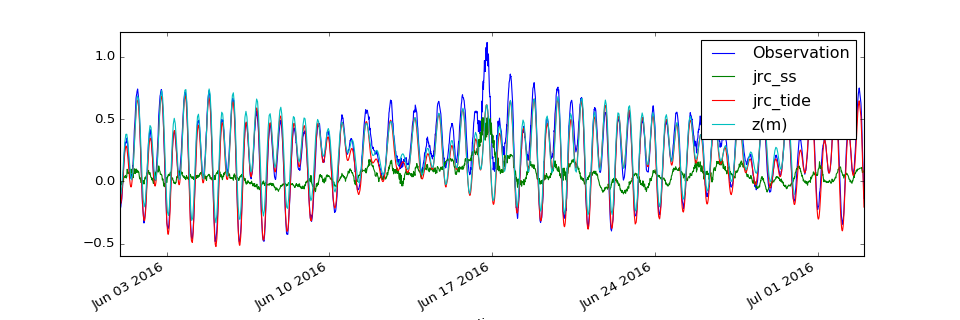

In [74]:
# PLOT TOGETHER
ax3=dat1.plot(figsize=(12,4))
dat.plot(ax=ax3)

In [75]:
# set a tide object to validate
to=copy.deepcopy(tide)

In [76]:
to.model['amplitude']

array([  9.34309975e-18,   1.31420598e-01,   1.57094413e+01,
         6.98474824e-01,   3.40141439e+00,   2.60638644e-03,
         3.64269750e-03,   1.67188464e-03,   4.54452307e-03,
         1.45758074e-03,   2.81916111e-03,   7.12313903e-01,
         1.04444888e-03,   1.81314140e-01,   1.34626082e-01,
         2.76449870e-02,   1.85509167e+00,   6.32559327e+00,
         5.24214956e-02,   2.92349070e-02,   1.33134676e-01,
         1.72218184e-01,   1.39407990e-01,   1.53260379e-01,
         2.93889867e+00,   2.14040664e+01,   2.46355154e-02,
         3.34297886e+00,   1.44093721e-02,   2.85986366e-03,
         2.21250839e+00,   6.77526044e-03,   1.14223658e+01,
         1.85546039e-03,   6.67833892e-04])

In [77]:
k=0
for c,a,p in to.model:
    if c.name in pcst.index:
        to.model['amplitude'][k] = pcst['amplitude'][c.name]
        to.model['phase'][k] = pcst['phase'][c.name]
    else:
        to.model['amplitude'][k]=0.
        to.model['phase'][k]=0.
    k +=1    

In [78]:
to.model['amplitude']

array([ 0.   ,  0.236,  0.152,  0.032,  0.145,  0.001,  0.033,  0.   ,
        0.   ,  0.   ,  0.001,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.007,  0.   ,  0.007,
        0.   ,  0.   ,  0.   ,  0.044,  0.   ,  0.   ,  0.   ,  0.   ,
        0.036,  0.   ,  0.001])

#### computing tide

In [79]:
dates=pandas.date_range(start='2016-06-01',end='2016-06-30',freq='6T')

In [80]:
hours=np.cumsum(np.r_[0, [t.total_seconds()/3600.0 for t in np.diff(dates.to_pydatetime())]])

In [81]:
times=pytides.tide.Tide._times(dates[0], hours)

In [84]:
tpx08 = pandas.Series(to.at(times) + dat1['Observation'].values.mean(), index=dates)

<IPython.core.display.Javascript object>


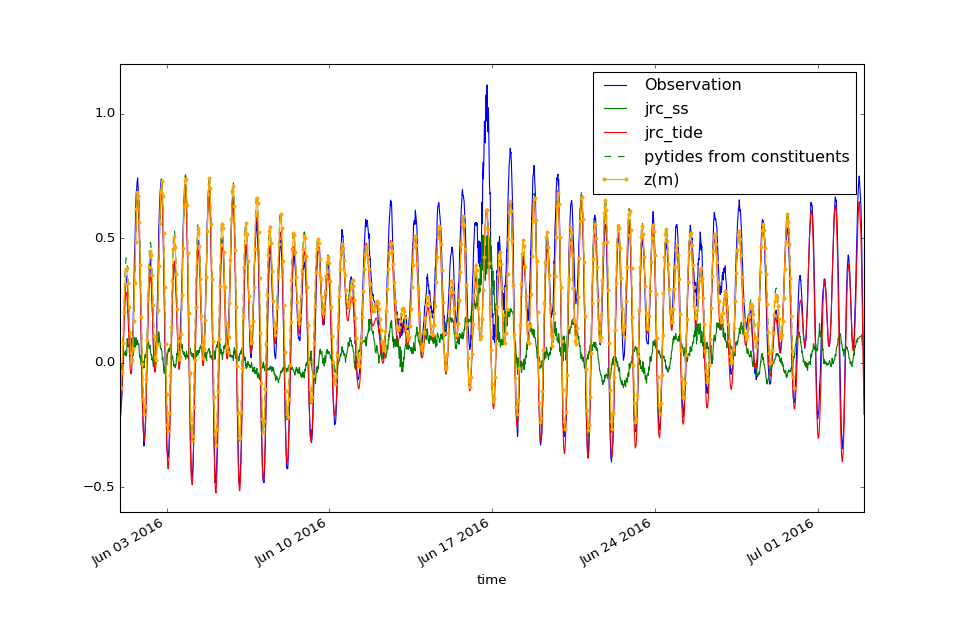

In [85]:
ax = dat1.plot(figsize=(12,8), label='Observed data')
tpx08.plot(ax=ax, color='green', linestyle='--', label='pytides from constituents')
#validation.plot(ax=ax, color='k', linestyle='--', label='pytides from Observed Data')
dat.plot(ax=ax, color='orange', linestyle='-', marker='.', label='tpx08 prediction')
leg=ax.legend(loc='best')

## Get the values from DELTARES med.nc

In [86]:
dmed=Dataset(path+'../med.nc')

In [87]:
dmed.variables.keys()

[u'crs',
 u'lon',
 u'lat',
 u'lon_u',
 u'lat_u',
 u'lon_v',
 u'lat_v',
 u'tidal_constituents',
 u'tidal_amplitude_h',
 u'tidal_phase_h',
 u'tidal_amplitude_u',
 u'tidal_phase_u',
 u'tidal_amplitude_v',
 u'tidal_phase_v',
 u'tidal_amplitude_U',
 u'tidal_phase_U',
 u'tidal_amplitude_V',
 u'tidal_phase_V',
 u'depth']

In [88]:
lat=dmed['lat'][:]
lon=dmed['lon'][:]

In [89]:
print lon.min(), lon.max()
print lat.min(), lat.max()

-7.99999974585 42.9999997459
30.0000002538 46.9999997462


In [90]:
i=np.abs(lon-np.float(plon)).argmin()
j=np.abs(lat-np.float(plat)).argmin()

In [91]:
print plat, lat[j]
print plon, lon[i]

45.418 45.4333331263
12.427 12.4333333838


In [100]:
tidal_c=dmed['tidal_constituents'][:]

In [101]:
tidal_c=[''.join(k).upper().strip() for k in tidal_c]
tidal_c    

['M2', 'S2', 'N2', 'K2', 'K1', 'O1', 'P1', 'Q1']

In [102]:
print dmed['tidal_amplitude_h'].shape

(1531, 511, 8)


In [103]:
amp=dmed['tidal_amplitude_h'][i,j,:]
amp

array([ 0.23731034,  0.15206292,  0.03239518,  0.03571473,  0.14507183,
        0.0331787 ,  0.04368611,  0.00655044], dtype=float32)

In [104]:
ph=dmed['tidal_phase_h'][i,j,:]
ph

array([ 261.1149292 ,  263.78164673,  266.3237915 ,  267.83203125,
         60.66874313,   61.92032623,   62.16405869,   95.00758362], dtype=float32)

In [105]:
dd=np.array([amp,ph]).T
dd

array([[  2.37310335e-01,   2.61114929e+02],
       [  1.52062923e-01,   2.63781647e+02],
       [  3.23951840e-02,   2.66323792e+02],
       [  3.57147306e-02,   2.67832031e+02],
       [  1.45071834e-01,   6.06687431e+01],
       [  3.31786983e-02,   6.19203262e+01],
       [  4.36861068e-02,   6.21640587e+01],
       [  6.55044243e-03,   9.50075836e+01]], dtype=float32)

In [106]:
df=pandas.DataFrame(dd, columns=['amplitude','phase'], index=tidal_c)
df

,amplitude,phase
M2,0.237310,261.114929
S2,0.152063,263.781647
N2,0.032395,266.323792
K2,0.035715,267.832031
K1,0.145072,60.668743
O1,0.033179,61.920326
P1,0.043686,62.164059
Q1,0.006550,95.007584


In [107]:
# set a tide object to validate
tomed=copy.deepcopy(tide)

In [108]:
k=0
for c,a,p in tomed.model:
    if c.name in df.index:
        tomed.model['amplitude'][k] = df['amplitude'][c.name]
        tomed.model['phase'][k] = df['phase'][c.name]
    else:
        tomed.model['amplitude'][k]=0.
        tomed.model['phase'][k]=0.
    k +=1    

In [109]:
tomed.model['amplitude']

array([ 0.        ,  0.23731034,  0.15206292,  0.03239518,  0.14507183,
        0.        ,  0.0331787 ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.00655044,  0.        ,
        0.        ,  0.        ,  0.04368611,  0.        ,  0.        ,
        0.        ,  0.        ,  0.03571473,  0.        ,  0.        ])

In [110]:
tomed.model['phase']

array([   0.        ,  261.1149292 ,  263.78164673,  266.3237915 ,
         60.66874313,    0.        ,   61.92032623,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,   95.00758362,
          0.        ,    0.        ,    0.        ,   62.16405869,
          0.        ,    0.        ,    0.        ,    0.        ,
        267.83203125,    0.        ,    0.        ])

In [111]:
dates=pandas.date_range(start='2016-06-01',end='2016-06-30',freq='6T')

In [112]:
hours=np.cumsum(np.r_[0, [t.total_seconds()/3600.0 for t in np.diff(dates.to_pydatetime())]])

In [113]:
times=pytides.tide.Tide._times(dates[0], hours)

In [116]:
med_deltares = pandas.Series(tomed.at(times) + dat1['Observation'].values.mean(), index=dates)

<IPython.core.display.Javascript object>


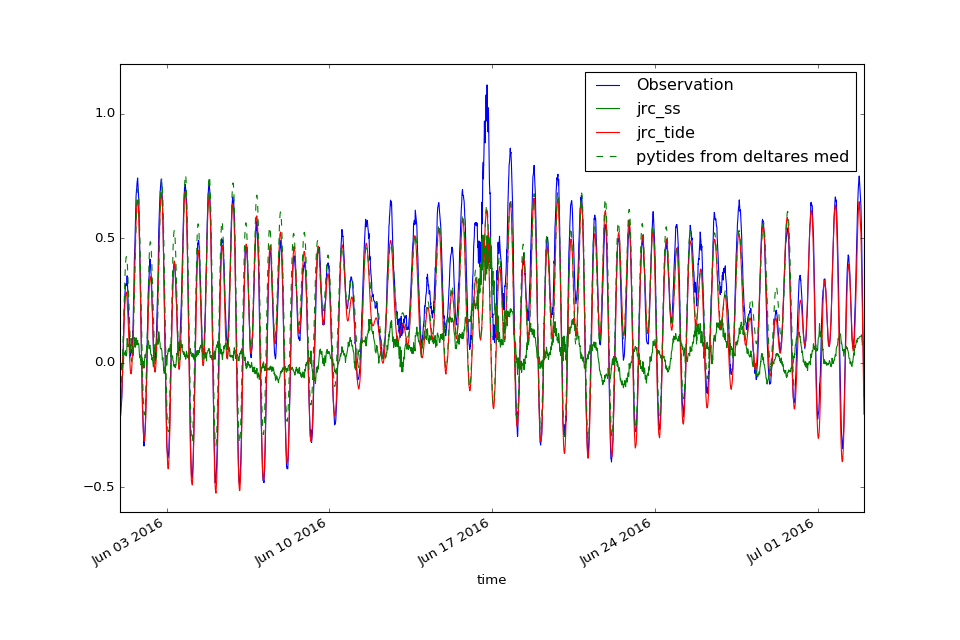

In [117]:
ax = dat1.plot(figsize=(12,8), label='Observed data')
med_deltares.plot(ax=ax, color='green', linestyle='--', label='pytides from deltares med')
leg=ax.legend(loc='best')

## Get the values from DELTARES tpxo72.nc

In [ ]:
tpx7=Dataset(path+'../tpxo72.nc')

In [ ]:
tpx7.variables.keys()

In [ ]:
lat7=tpx7['lat'][:]
lon7=tpx7['lon'][:]

In [ ]:
print lon7.min(), lon7.max()
print lat7.min(), lat7.max()

In [ ]:
i7=np.abs(lon7-np.float(plon)).argmin()
j7=np.abs(lat7-np.float(plat)).argmin()

In [ ]:
print plat, lat7[j7]
print plon, lon7[i7]

In [ ]:
tidal_c7=tpx7['tidal_constituents'][:]

In [ ]:
tidal_c7=[''.join(k).upper().strip() for k in tidal_c7]
tidal_c7    

In [ ]:
tidal_c7[-5]='Mf' # make compatible with pytides

In [ ]:
print tpx7['tidal_amplitude_h'].shape

In [ ]:
amp7=tpx7['tidal_amplitude_h'][i7,j7,:]
amp7

In [ ]:
ph7=tpx7['tidal_phase_h'][i7,j7,:]
ph7

In [ ]:
dd7=np.array([amp7,ph7]).T
dd7

In [ ]:
df7=pandas.DataFrame(dd7, columns=['amplitude','phase'], index=tidal_c7)
df7

In [ ]:
# set a tide object to validate
to7=copy.deepcopy(tide)

In [ ]:
k=0
for c,a,p in to7.model:
    if c.name in df7.index:
        to7.model['amplitude'][k] = df7['amplitude'][c.name]
        to7.model['phase'][k] = df7['phase'][c.name]
    else:
        to7.model['amplitude'][k]=0.
        to7.model['phase'][k]=0.
    k +=1    

In [ ]:
to7.model['amplitude']

In [ ]:
to7.model['phase']

In [ ]:
dates=pandas.date_range(start='2016-06-01',end='2016-06-30',freq='6T')

In [ ]:
hours=np.cumsum(np.r_[0, [t.total_seconds()/3600.0 for t in np.diff(dates.to_pydatetime())]])

In [ ]:
times=pytides.tide.Tide._times(dates[0], hours)

In [ ]:
med7 = pandas.Series(to7.at(times) + dat1['elev'].values.mean(), index=dates)

In [ ]:
ax = dat1.plot(figsize=(12,8), label='Observed data')
med7.plot(ax=ax, color='green', linestyle='--', label='pytides from deltares tpx7.2')
med_deltares.plot(ax=ax, color='red', linestyle='--', label='pytides from deltares med')
dat.plot(ax=ax, color='orange', linestyle='-', marker='.', label='pytides from tpx8')
leg=ax.legend(loc='best')